# Data Cleaning and Modelling

In [1]:
!pip install openpyxl

In [2]:
!pip install xgboost

In [3]:
!pip install shap

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
import warnings

In [5]:
data = pd.read_excel('app_data.xlsx')
data

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Management,Severity,Diagnosis_Presumptive,Diagnosis,...,Abscess_Location,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings
0,12.680000,16.900000,female,148.0,37.0,3.0,conservative,uncomplicated,appendicitis,appendicitis,...,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,14.100000,31.900000,male,147.0,69.5,2.0,conservative,uncomplicated,appendicitis,no appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN
2,14.140000,23.300000,female,163.0,62.0,4.0,conservative,uncomplicated,appendicitis,no appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,yes,NaN
3,16.370000,20.600000,female,165.0,56.0,3.0,conservative,uncomplicated,appendicitis,no appendicitis,...,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,yes,NaN
4,11.080000,16.900000,female,163.0,45.0,3.0,conservative,uncomplicated,appendicitis,appendicitis,...,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,12.413415,25.250476,female,166.5,70.0,4.0,primary surgical,uncomplicated,appendicitis,appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
777,17.092402,20.429418,female,158.0,51.0,6.0,secondary surgical,complicated,appendicitis,appendicitis,...,Douglas,NaN,NaN,yes,yes,NaN,NaN,NaN,NaN,NaN
778,14.992471,19.909972,female,152.0,46.0,4.0,primary surgical,uncomplicated,appendicitis,appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unauffällig
779,7.195072,14.295549,male,129.3,23.9,5.0,primary surgical,uncomplicated,appendicitis,appendicitis,...,NaN,no,NaN,yes,NaN,no,NaN,NaN,NaN,NaN


In [6]:
data = data.iloc[:,:39]

In [7]:
print(data.columns)

Index(['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Management',
       'Severity', 'Diagnosis_Presumptive', 'Diagnosis', 'Alvarado_Score',
       'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter',
       'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count',
       'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia',
       'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count',
       'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria',
       'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness',
       'US_Performed'],
      dtype='object')


In [8]:
data.isnull().sum()

Age                                   0
BMI                                  26
Sex                                   1
Height                               25
Weight                                2
Length_of_Stay                        3
Management                            0
Severity                              0
Diagnosis_Presumptive                 1
Diagnosis                             1
Alvarado_Score                       51
Paedriatic_Appendicitis_Score        51
Appendix_on_US                        4
Appendix_Diameter                   283
Migratory_Pain                        8
Lower_Right_Abd_Pain                  7
Contralateral_Rebound_Tenderness     14
Coughing_Pain                        15
Nausea                                7
Loss_of_Appetite                      9
Body_Temperature                      6
WBC_Count                             5
Neutrophil_Percentage               102
Segmented_Neutrophils               727
Neutrophilia                         49


In [9]:
data2 = data[['Age','BMI','Sex','Neutrophil_Percentage','WBC_Count','Neutrophilia','Ketones_in_Urine','Peritonitis','Lower_Right_Abd_Pain','Contralateral_Rebound_Tenderness','Ipsilateral_Rebound_Tenderness','Loss_of_Appetite','Body_Temperature','Diagnosis']]

In [10]:
ketone_map = {'no':0,'+':1,'++':2,'+++':3}
data2.loc[:,['Ketones_in_Urine']] = data2['Ketones_in_Urine'].map(ketone_map)
peritonitis_map = {'no':0, 'local':1, 'generalized':2}
data2.loc[:,['Peritonitis']] = data2['Peritonitis'].map(peritonitis_map)
diag_map = {'appendicitis':1,'no appendicitis':0}
data2['Diagnosis'] = data2['Diagnosis'].map(diag_map)
data2

C:\Users\Mahima Batheja\AppData\Local\Temp\ipykernel_63396\1796412032.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Diagnosis'] = data2['Diagnosis'].map(diag_map)


,Age,BMI,Sex,Neutrophil_Percentage,WBC_Count,Neutrophilia,Ketones_in_Urine,Peritonitis,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Ipsilateral_Rebound_Tenderness,Loss_of_Appetite,Body_Temperature,Diagnosis
0,12.680000,16.900000,female,68.2,7.7,no,2.0,0.0,yes,yes,no,yes,37.0,1.0
1,14.100000,31.900000,male,64.8,8.1,no,0.0,0.0,yes,yes,no,yes,36.9,0.0
2,14.140000,23.300000,female,74.8,13.2,no,0.0,0.0,yes,yes,no,no,36.6,0.0
3,16.370000,20.600000,female,63.0,11.4,no,0.0,0.0,yes,no,no,yes,36.0,0.0
4,11.080000,16.900000,female,44.0,8.1,no,0.0,0.0,yes,yes,no,yes,36.9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,12.413415,25.250476,female,76.6,11.4,yes,NaN,1.0,yes,no,NaN,yes,39.4,1.0
777,17.092402,20.429418,female,89.2,17.4,yes,NaN,1.0,no,no,NaN,yes,37.8,1.0
778,14.992471,19.909972,female,68.5,14.6,no,0.0,0.0,yes,no,no,no,37.3,1.0
779,7.195072,14.295549,male,77.0,17.8,yes,3.0,1.0,yes,no,no,no,37.5,1.0


In [11]:
print(data2['Sex'].unique())
sex_map = {'female':0,'male':1}
data2['Sex'] = data2['Sex'].map(sex_map)
affirm_map = {'no':0,'yes':1}
cols = ['Neutrophilia','Lower_Right_Abd_Pain','Contralateral_Rebound_Tenderness','Ipsilateral_Rebound_Tenderness','Loss_of_Appetite']
data2[cols] = data2[cols].applymap(affirm_map.get)
print(data2['Sex'].head())
print(data2.dtypes)

['female' 'male' nan]
0    0.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: Sex, dtype: float64
Age                                 float64
BMI                                 float64
Sex                                 float64
Neutrophil_Percentage               float64
WBC_Count                           float64
Neutrophilia                        float64
Ketones_in_Urine                     object
Peritonitis                          object
Lower_Right_Abd_Pain                float64
Contralateral_Rebound_Tenderness    float64
Ipsilateral_Rebound_Tenderness      float64
Loss_of_Appetite                    float64
Body_Temperature                    float64
Diagnosis                           float64
dtype: object


C:\Users\Mahima Batheja\AppData\Local\Temp\ipykernel_63396\1681428522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['Sex'] = data2['Sex'].map(sex_map)
C:\Users\Mahima Batheja\AppData\Local\Temp\ipykernel_63396\1681428522.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data2[cols] = data2[cols].applymap(affirm_map.get)
C:\Users\Mahima Batheja\AppData\Local\Temp\ipykernel_63396\1681428522.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2[cols] = da

In [12]:
data2.isnull().sum()

Age                                   0
BMI                                  26
Sex                                   1
Neutrophil_Percentage               102
WBC_Count                             5
Neutrophilia                         49
Ketones_in_Urine                    199
Peritonitis                           8
Lower_Right_Abd_Pain                  7
Contralateral_Rebound_Tenderness     14
Ipsilateral_Rebound_Tenderness      162
Loss_of_Appetite                      9
Body_Temperature                      6
Diagnosis                             1
dtype: int64

In [13]:
data2

,Age,BMI,Sex,Neutrophil_Percentage,WBC_Count,Neutrophilia,Ketones_in_Urine,Peritonitis,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Ipsilateral_Rebound_Tenderness,Loss_of_Appetite,Body_Temperature,Diagnosis
0,12.680000,16.900000,0.0,68.2,7.7,0.0,2.0,0.0,1.0,1.0,0.0,1.0,37.0,1.0
1,14.100000,31.900000,1.0,64.8,8.1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,36.9,0.0
2,14.140000,23.300000,0.0,74.8,13.2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,36.6,0.0
3,16.370000,20.600000,0.0,63.0,11.4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,36.0,0.0
4,11.080000,16.900000,0.0,44.0,8.1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,36.9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,12.413415,25.250476,0.0,76.6,11.4,1.0,NaN,1.0,1.0,0.0,NaN,1.0,39.4,1.0
777,17.092402,20.429418,0.0,89.2,17.4,1.0,NaN,1.0,0.0,0.0,NaN,1.0,37.8,1.0
778,14.992471,19.909972,0.0,68.5,14.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.3,1.0
779,7.195072,14.295549,1.0,77.0,17.8,1.0,3.0,1.0,1.0,0.0,0.0,0.0,37.5,1.0


In [14]:
data2.isnull().sum()

Age                                   0
BMI                                  26
Sex                                   1
Neutrophil_Percentage               102
WBC_Count                             5
Neutrophilia                         49
Ketones_in_Urine                    199
Peritonitis                           8
Lower_Right_Abd_Pain                  7
Contralateral_Rebound_Tenderness     14
Ipsilateral_Rebound_Tenderness      162
Loss_of_Appetite                      9
Body_Temperature                      6
Diagnosis                             1
dtype: int64

In [15]:
missing_pattern = data2.isnull().any(axis=1)
print(f"A total of {missing_pattern.sum()} patients had at least one record missing")

A total of 363 patients had at least one record missing


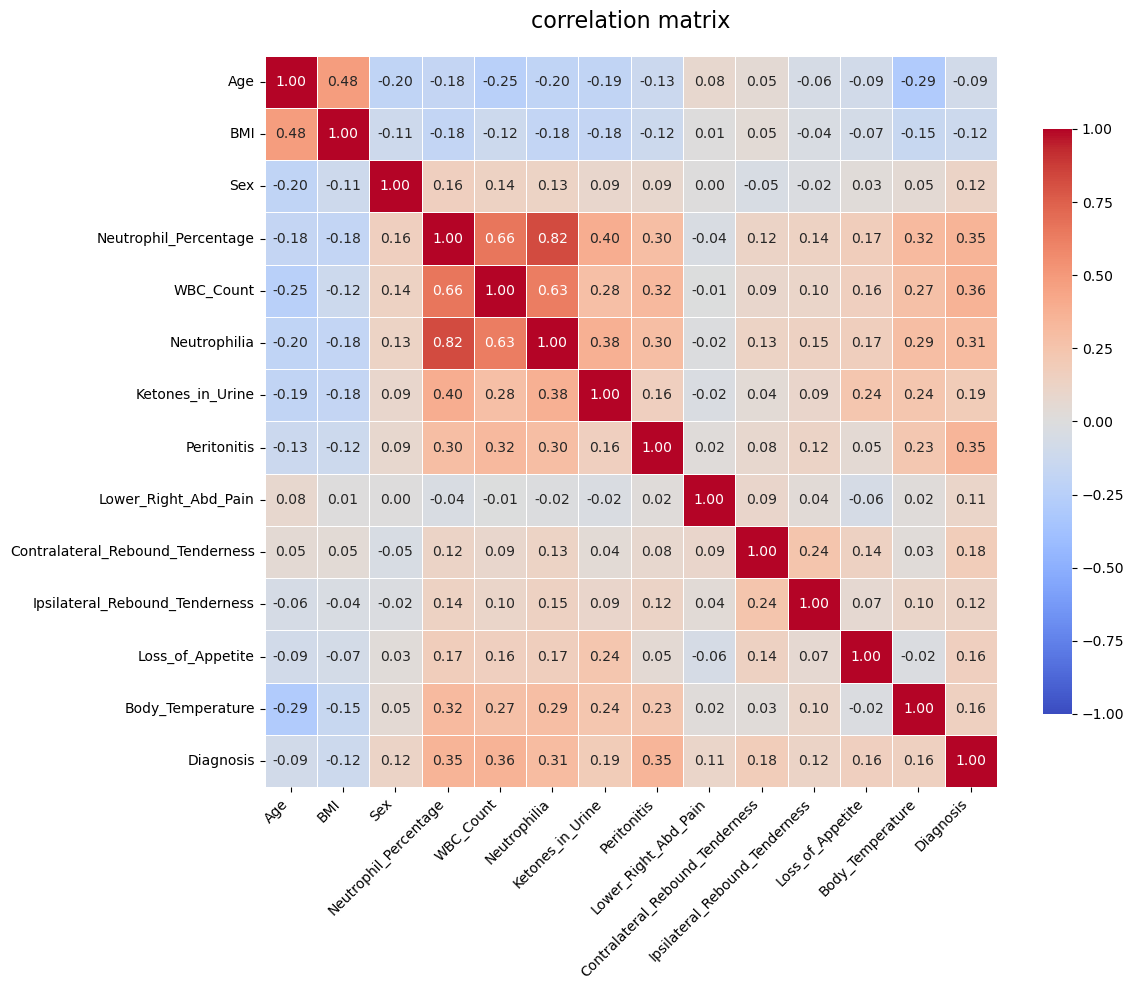

In [16]:
correlation = data2.corr()
plt.figure(figsize=(12,10))

heatmap = sns.heatmap(correlation,
                     annot=True,
                     fmt= ".2f",
                     cmap='coolwarm',
                     vmin=-1,
                     vmax=1,
                     center=0,
                     linewidths=.5,
                     cbar_kws={"shrink":0.8})

plt.title('correlation matrix', pad=20, fontsize=16)

heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')

heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

In [17]:
data2 = data2.dropna(subset=['Diagnosis'])
data2

,Age,BMI,Sex,Neutrophil_Percentage,WBC_Count,Neutrophilia,Ketones_in_Urine,Peritonitis,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Ipsilateral_Rebound_Tenderness,Loss_of_Appetite,Body_Temperature,Diagnosis
0,12.680000,16.900000,0.0,68.2,7.7,0.0,2.0,0.0,1.0,1.0,0.0,1.0,37.0,1.0
1,14.100000,31.900000,1.0,64.8,8.1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,36.9,0.0
2,14.140000,23.300000,0.0,74.8,13.2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,36.6,0.0
3,16.370000,20.600000,0.0,63.0,11.4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,36.0,0.0
4,11.080000,16.900000,0.0,44.0,8.1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,36.9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,12.413415,25.250476,0.0,76.6,11.4,1.0,NaN,1.0,1.0,0.0,NaN,1.0,39.4,1.0
777,17.092402,20.429418,0.0,89.2,17.4,1.0,NaN,1.0,0.0,0.0,NaN,1.0,37.8,1.0
778,14.992471,19.909972,0.0,68.5,14.6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,37.3,1.0
779,7.195072,14.295549,1.0,77.0,17.8,1.0,3.0,1.0,1.0,0.0,0.0,0.0,37.5,1.0


1️⃣modelling with all  variables
Fitting 3 folds for each of 8 candidates, totalling 24 fits
 Model: Logistic Regression
 Best Parameters: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__C': 1}
 Accuracy: 0.7115384615384616
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.57      0.62        63
         1.0       0.74      0.81      0.77        93

    accuracy                           0.71       156
   macro avg       0.70      0.69      0.69       156
weighted avg       0.71      0.71      0.71       156



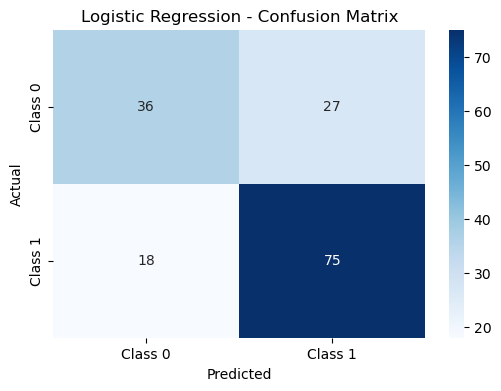

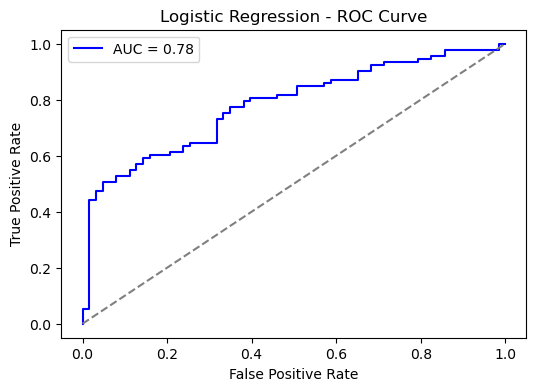

Fitting 3 folds for each of 6 candidates, totalling 18 fits
 Model: Random Forest
 Best Parameters: {'model__n_estimators': 200, 'model__max_depth': 10}
 Accuracy: 0.75
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.63      0.67        63
         1.0       0.77      0.83      0.80        93

    accuracy                           0.75       156
   macro avg       0.74      0.73      0.74       156
weighted avg       0.75      0.75      0.75       156



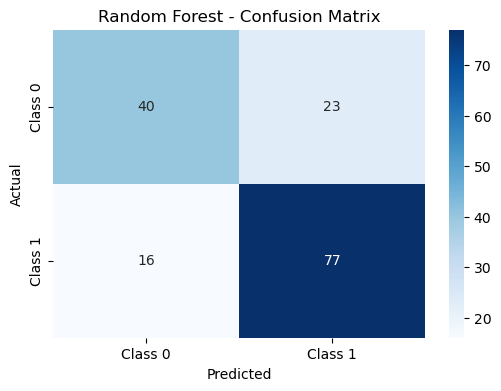

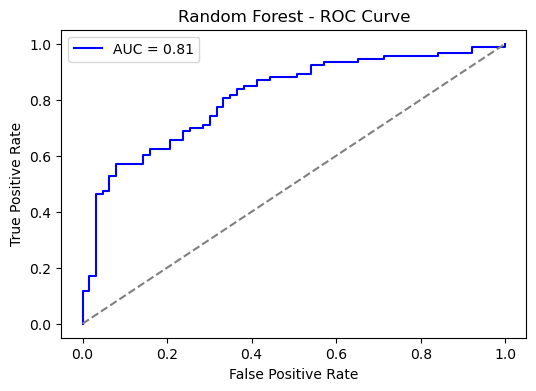

Fitting 3 folds for each of 10 candidates, totalling 30 fits
 Model: Gradient Boosting
 Best Parameters: {'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.01}
 Accuracy: 0.717948717948718
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.65      0.65        63
         1.0       0.76      0.76      0.76        93

    accuracy                           0.72       156
   macro avg       0.71      0.71      0.71       156
weighted avg       0.72      0.72      0.72       156



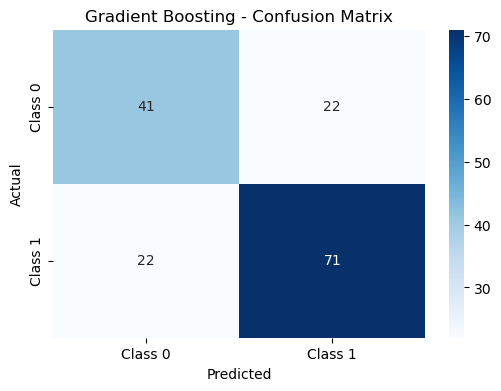

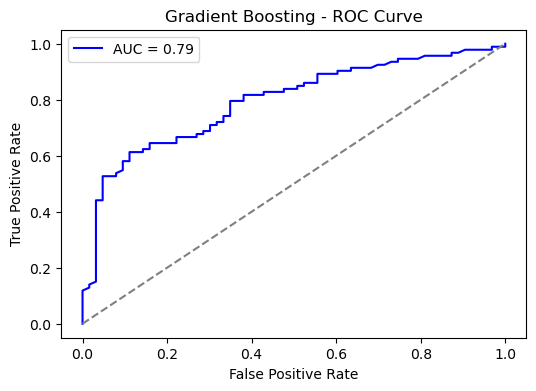

Fitting 3 folds for each of 6 candidates, totalling 18 fits
 Model: XGBoost
 Best Parameters: {'model__max_depth': 3, 'model__learning_rate': 0.1}
 Accuracy: 0.7051282051282052
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.66      0.56      0.60        63
         1.0       0.73      0.81      0.77        93

    accuracy                           0.71       156
   macro avg       0.69      0.68      0.68       156
weighted avg       0.70      0.71      0.70       156



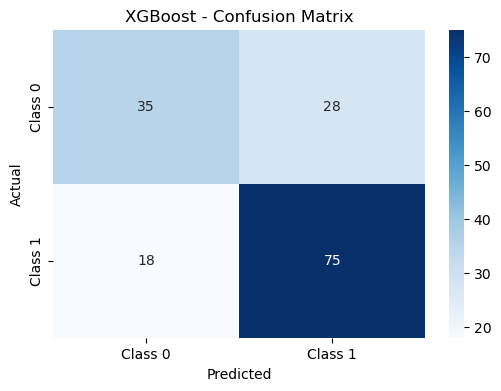

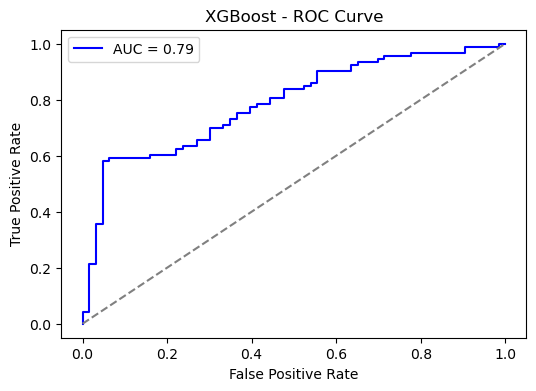

In [18]:
print("1️⃣modelling with all  variables")

warnings.filterwarnings("ignore")

# Define your features and target
numeric_features = ['Age', 'BMI', 'Neutrophil_Percentage', 'WBC_Count', 'Body_Temperature']

binary_features = ['Sex', 'Neutrophilia', 'Lower_Right_Abd_Pain',
                   'Contralateral_Rebound_Tenderness', 'Ipsilateral_Rebound_Tenderness',
                   'Loss_of_Appetite']

multi_class_cat_features = ['Peritonitis', 'Ketones_in_Urine']  # more than 2 categories

# Numeric: Impute + Scale
numeric_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Binary: Impute only (already 0/1)
binary_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5))
])

# Multi-class categorical: Impute + OneHotEncode
multi_cat_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine all into one preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('bin', binary_pipeline, binary_features),
    ('multi_cat', multi_cat_pipeline, multi_class_cat_features)
])

#load data

X = data2[numeric_features+binary_features+multi_class_cat_features]
y = data2['Diagnosis']

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit the pipeline
#pipeline.fit(X_train, y_train)

# Models to try
models = [
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]
best_rf_model = None #variable to store random forest pipeline

# Loop through and train each model
for name, model in models:
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Define hyperparams to search
    param_distributions = {}
    if name == "Logistic Regression":
        param_distributions = {
            "model__C": [0.01, 0.1, 1, 10],
            "model__penalty": ["l1", "l2"],
            "model__solver": ["liblinear"]
        }
    elif name == "Random Forest":
        param_distributions = {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 10, 20]
        }
    elif name == "Gradient Boosting":
        param_distributions = {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.01, 0.1],
            "model__max_depth": [3, 4, 5]
        }
    elif name == "XGBoost":
        param_distributions = {
            "model__max_depth": [3, 4, 5],
            "model__learning_rate": [0.01, 0.1]
        }

    randomized_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        cv=3,
        scoring="roc_auc",
        verbose=2,
        n_jobs=-1
    )

    randomized_search.fit(X_train, y_train)

    best_model = randomized_search.best_estimator_
    y_pred = best_model.predict(X_val)

    if name == "Random Forest":
        best_rf_model = best_model

    print(f" Model: {name}")
    print(" Best Parameters:", randomized_search.best_params_)
    print(" Accuracy:", accuracy_score(y_val, y_pred))
    print(" Classification Report:\n", classification_report(y_val, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    if hasattr(best_model.named_steps["model"], "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        auc_score = roc_auc_score(y_val, y_pred_proba)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='blue')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"{name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

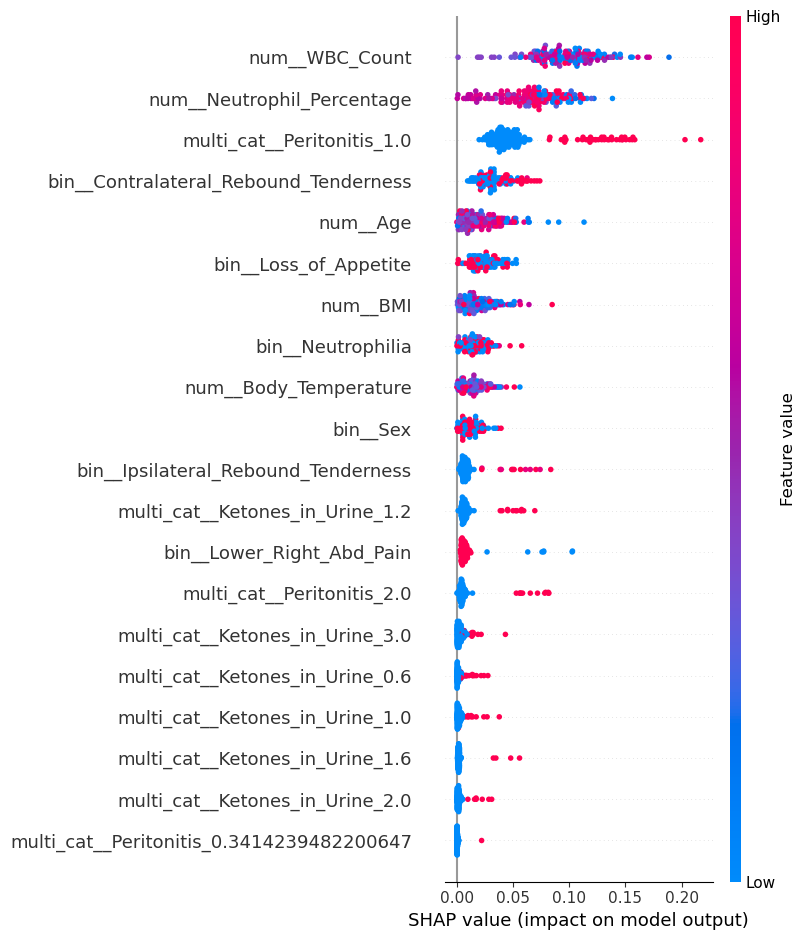

In [19]:
#sensitivity analysis with SHAP values
#Extract the fitted model and preprocessor
rf = best_rf_model.named_steps["model"]
pre = best_rf_model.named_steps["preprocessor"]

#Transform X_val using fitted preprocessor
X_val_transformed = pre.transform(X_val)

#Get correct feature names from fitted preprocessor
feature_names = pre.get_feature_names_out()

#Create SHAP explainer on model
explainer = shap.TreeExplainer(rf)

#Compute SHAP values
shap_values = explainer.shap_values(X_val_transformed)

shap_values_mean = np.mean(np.abs(shap_values), axis=2)  # shape (84, 12)

# Plot summary using mean SHAP values
shap.summary_plot(shap_values_mean, X_val_transformed, feature_names=feature_names)

2️⃣modelling without ketones in urine
Fitting 3 folds for each of 8 candidates, totalling 24 fits
 Model: Logistic Regression
 Best Parameters: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__C': 1}
 Accuracy: 0.7051282051282052
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.57      0.61        63
         1.0       0.73      0.80      0.76        93

    accuracy                           0.71       156
   macro avg       0.69      0.68      0.69       156
weighted avg       0.70      0.71      0.70       156



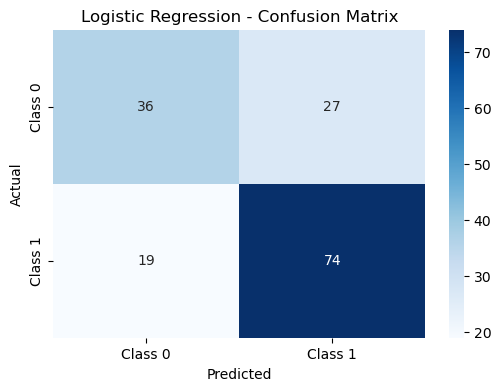

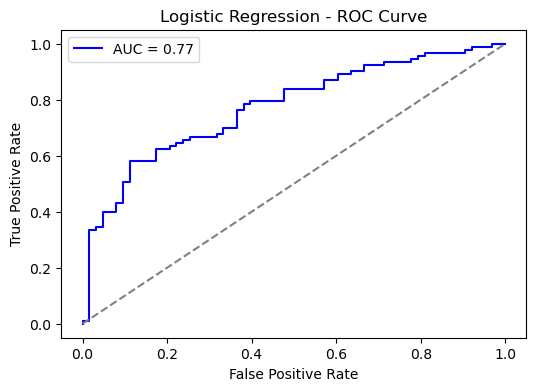

Fitting 3 folds for each of 6 candidates, totalling 18 fits
 Model: Random Forest
 Best Parameters: {'model__n_estimators': 200, 'model__max_depth': 20}
 Accuracy: 0.7371794871794872
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.57      0.64        63
         1.0       0.75      0.85      0.79        93

    accuracy                           0.74       156
   macro avg       0.73      0.71      0.72       156
weighted avg       0.74      0.74      0.73       156



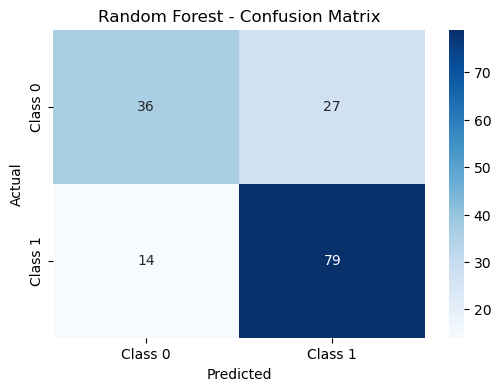

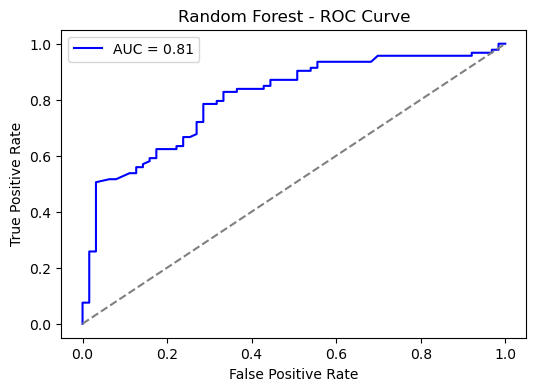

Fitting 3 folds for each of 10 candidates, totalling 30 fits
 Model: Gradient Boosting
 Best Parameters: {'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.01}
 Accuracy: 0.7243589743589743
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.66      0.65      0.66        63
         1.0       0.77      0.77      0.77        93

    accuracy                           0.72       156
   macro avg       0.71      0.71      0.71       156
weighted avg       0.72      0.72      0.72       156



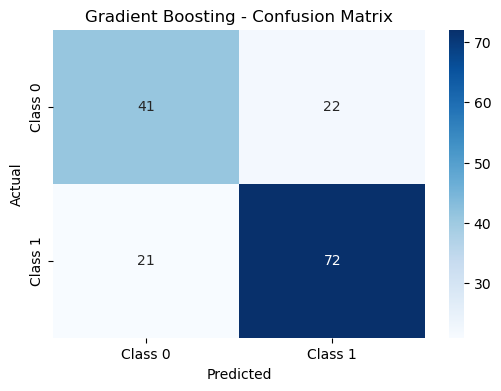

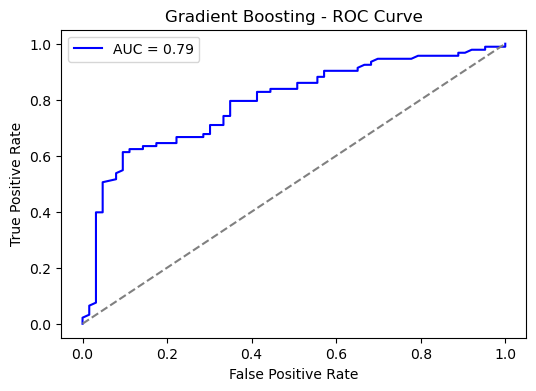

Fitting 3 folds for each of 6 candidates, totalling 18 fits
 Model: XGBoost
 Best Parameters: {'model__max_depth': 3, 'model__learning_rate': 0.1}
 Accuracy: 0.6923076923076923
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.63      0.59      0.61        63
         1.0       0.73      0.76      0.75        93

    accuracy                           0.69       156
   macro avg       0.68      0.68      0.68       156
weighted avg       0.69      0.69      0.69       156



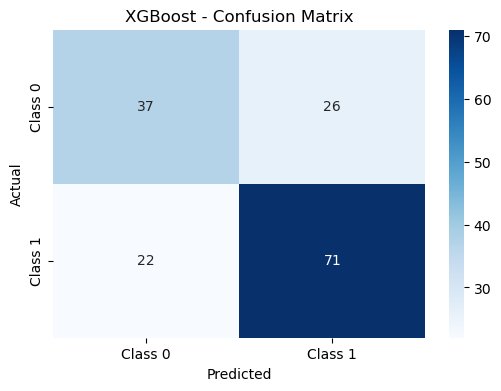

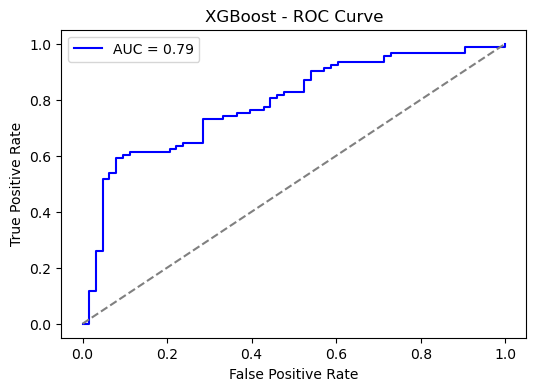

In [20]:
print("2️⃣modelling without ketones in urine")

warnings.filterwarnings("ignore")

# Define your features and target
numeric_features = ['Age', 'BMI', 'Neutrophil_Percentage', 'WBC_Count', 'Body_Temperature']

binary_features = ['Sex', 'Neutrophilia', 'Lower_Right_Abd_Pain',
                   'Contralateral_Rebound_Tenderness', 'Ipsilateral_Rebound_Tenderness',
                   'Loss_of_Appetite']

multi_class_cat_features = ['Peritonitis']  # more than 2 categories

# Numeric: Impute + Scale
numeric_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Binary: Impute only (already 0/1)
binary_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5))
])

# Multi-class categorical: Impute + OneHotEncode
multi_cat_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine all into one preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('bin', binary_pipeline, binary_features),
    ('multi_cat', multi_cat_pipeline, multi_class_cat_features)
])

#load data
all_features = numeric_features + binary_features + multi_class_cat_features

X = data2[all_features]
y = data2['Diagnosis']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the pipeline
#pipeline.fit(X_train, y_train)

# Models to try
models = [
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

best_rf_model = None #variable to store random forest pipeline

# Loop through and train each model
for name, model in models:
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Define hyperparams to search
    param_distributions = {}
    if name == "Logistic Regression":
        param_distributions = {
            "model__C": [0.01, 0.1, 1, 10],
            "model__penalty": ["l1", "l2"],
            "model__solver": ["liblinear"]
        }
    elif name == "Random Forest":
        param_distributions = {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 10, 20]
        }
    elif name == "Gradient Boosting":
        param_distributions = {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.01, 0.1],
            "model__max_depth": [3, 4, 5]
        }
    elif name == "XGBoost":
        param_distributions = {
            "model__max_depth": [3, 4, 5],
            "model__learning_rate": [0.01, 0.1]
        }

    randomized_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        cv=3,
        scoring="roc_auc",
        verbose=2,
        n_jobs=-1
    )

    randomized_search.fit(X_train, y_train)

    best_model = randomized_search.best_estimator_
    y_pred = best_model.predict(X_val)

    if name == "Random Forest":
        best_rf_model = best_model

    print(f" Model: {name}")
    print(" Best Parameters:", randomized_search.best_params_)
    print(" Accuracy:", accuracy_score(y_val, y_pred))
    print(" Classification Report:\n", classification_report(y_val, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    if hasattr(best_model.named_steps["model"], "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        auc_score = roc_auc_score(y_val, y_pred_proba)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='blue')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"{name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

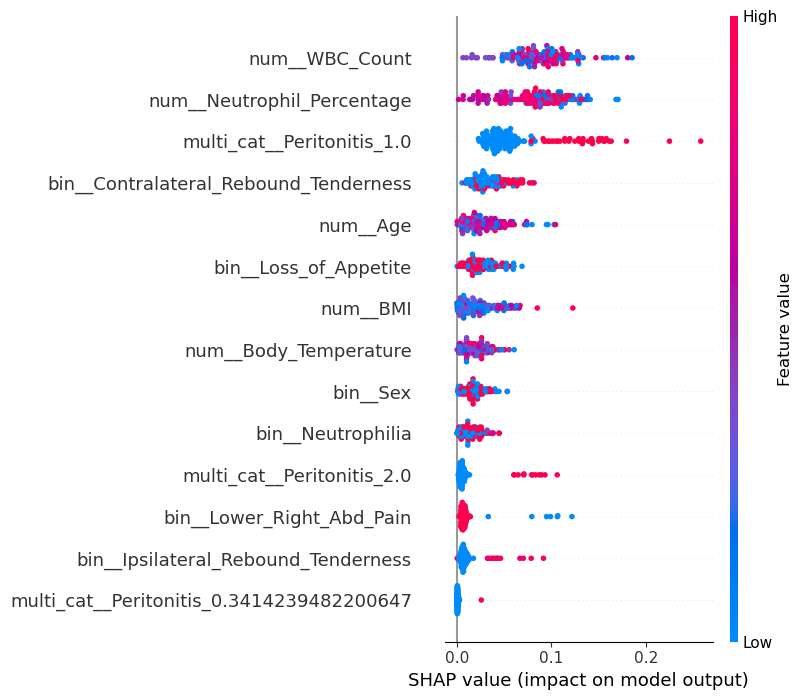

In [21]:
#sensitivity analysis with SHAP values
#Extract the fitted model and preprocessor
rf = best_rf_model.named_steps["model"]
pre = best_rf_model.named_steps["preprocessor"]

#Transform X_val using fitted preprocessor
X_val_transformed = pre.transform(X_val)

#Get correct feature names from fitted preprocessor
feature_names = pre.get_feature_names_out()

#Create SHAP explainer on model
explainer = shap.TreeExplainer(rf)

#Compute SHAP values
shap_values = explainer.shap_values(X_val_transformed)

shap_values_mean = np.mean(np.abs(shap_values), axis=2)  # shape (84, 12)

# Plot summary using mean SHAP values
shap.summary_plot(shap_values_mean, X_val_transformed, feature_names=feature_names)

3️⃣modelling without ketones in urine and ipsilateral rebound
Fitting 3 folds for each of 8 candidates, totalling 24 fits
 Model: Logistic Regression
 Best Parameters: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__C': 10}
 Accuracy: 0.7051282051282052
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.59      0.62        63
         1.0       0.74      0.78      0.76        93

    accuracy                           0.71       156
   macro avg       0.69      0.69      0.69       156
weighted avg       0.70      0.71      0.70       156



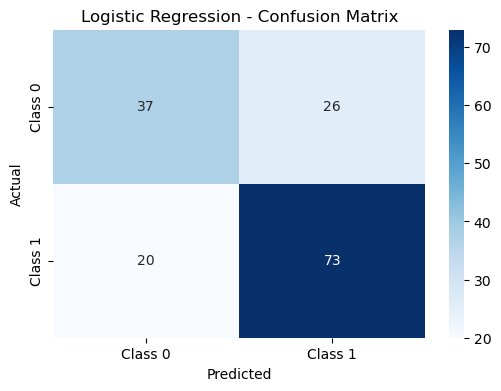

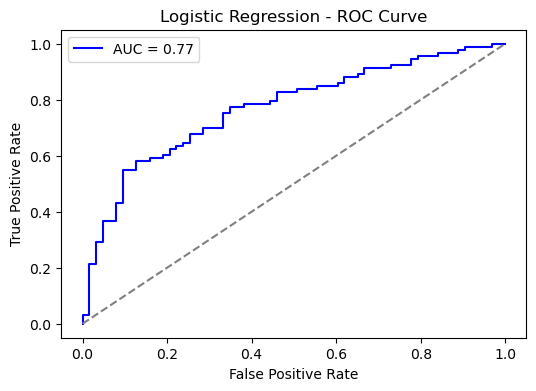

Fitting 3 folds for each of 6 candidates, totalling 18 fits
 Model: Random Forest
 Best Parameters: {'model__n_estimators': 200, 'model__max_depth': 10}
 Accuracy: 0.75
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.62      0.67        63
         1.0       0.76      0.84      0.80        93

    accuracy                           0.75       156
   macro avg       0.74      0.73      0.73       156
weighted avg       0.75      0.75      0.75       156



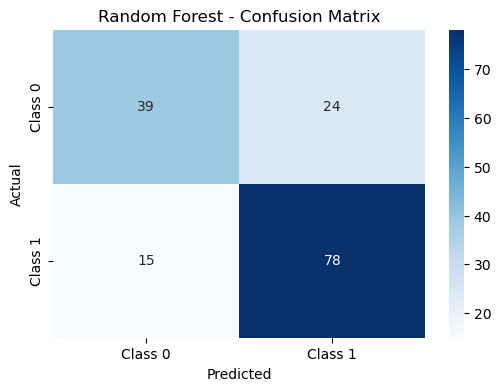

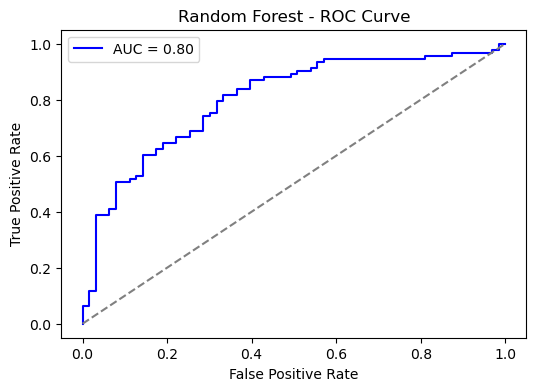

Fitting 3 folds for each of 10 candidates, totalling 30 fits
 Model: Gradient Boosting
 Best Parameters: {'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.01}
 Accuracy: 0.7307692307692307
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.67      0.67        63
         1.0       0.77      0.77      0.77        93

    accuracy                           0.73       156
   macro avg       0.72      0.72      0.72       156
weighted avg       0.73      0.73      0.73       156



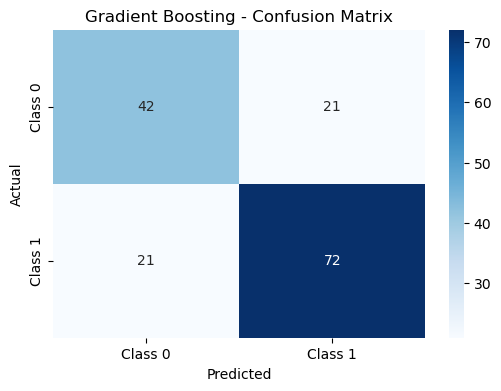

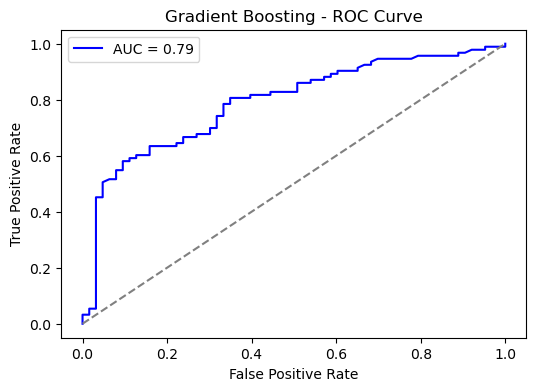

Fitting 3 folds for each of 6 candidates, totalling 18 fits
 Model: XGBoost
 Best Parameters: {'model__max_depth': 3, 'model__learning_rate': 0.1}
 Accuracy: 0.7051282051282052
 Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.57      0.61        63
         1.0       0.73      0.80      0.76        93

    accuracy                           0.71       156
   macro avg       0.69      0.68      0.69       156
weighted avg       0.70      0.71      0.70       156



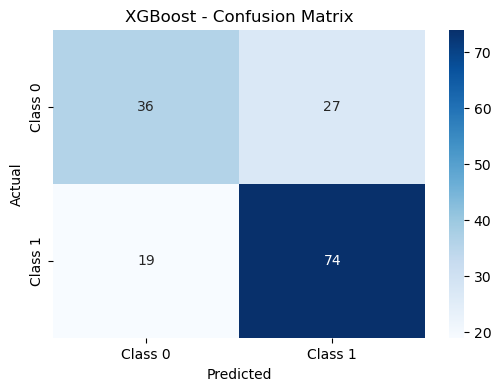

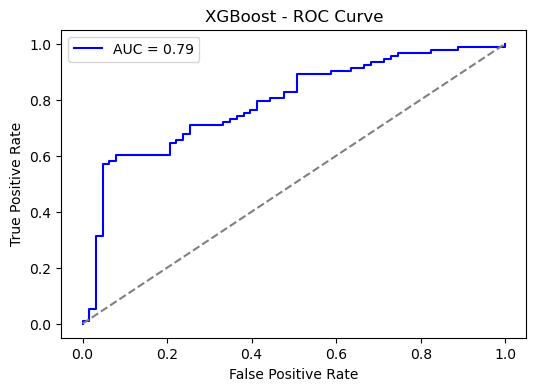

In [26]:
print("3️⃣modelling without ketones in urine and ipsilateral rebound")

warnings.filterwarnings("ignore")

# Define your features and target
numeric_features = ['Age', 'BMI', 'Neutrophil_Percentage', 'WBC_Count','Body_Temperature']

binary_features = ['Sex', 'Neutrophilia', 'Lower_Right_Abd_Pain',
                   'Contralateral_Rebound_Tenderness',
                   'Loss_of_Appetite']

multi_class_cat_features = ['Peritonitis']  # more than 2 categories

# Numeric: Impute + Scale
numeric_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Binary: Impute only (already 0/1)
binary_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5))
])

# Multi-class categorical: Impute + OneHotEncode
multi_cat_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine all into one preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('bin', binary_pipeline, binary_features),
    ('multi_cat', multi_cat_pipeline, multi_class_cat_features)
])

#load data
all_features = numeric_features + binary_features + multi_class_cat_features

X = data2[all_features]
y = data2['Diagnosis']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Fit the pipeline
#pipeline.fit(X_train, y_train)

# Models to try
models = [
    ("Logistic Regression", LogisticRegression()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

best_rf_model = None #variable to store random forest pipeline

# Loop through and train each model
for name, model in models:
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Define hyperparams to search
    param_distributions = {}
    if name == "Logistic Regression":
        param_distributions = {
            "model__C": [0.01, 0.1, 1, 10],
            "model__penalty": ["l1", "l2"],
            "model__solver": ["liblinear"]
        }
    elif name == "Random Forest":
        param_distributions = {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 10, 20]
        }
    elif name == "Gradient Boosting":
        param_distributions = {
            "model__n_estimators": [100, 200],
            "model__learning_rate": [0.01, 0.1],
            "model__max_depth": [3, 4, 5]
        }
    elif name == "XGBoost":
        param_distributions = {
            "model__max_depth": [3, 4, 5],
            "model__learning_rate": [0.01, 0.1]
        }

    randomized_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        cv=3,
        scoring="roc_auc",
        verbose=2,
        n_jobs=-1
    )

    randomized_search.fit(X_train, y_train)

    best_model = randomized_search.best_estimator_
    y_pred = best_model.predict(X_val)

    if name == "Random Forest":
        best_rf_model = best_model

    print(f" Model: {name}")
    print(" Best Parameters:", randomized_search.best_params_)
    print(" Accuracy:", accuracy_score(y_val, y_pred))
    print(" Classification Report:\n", classification_report(y_val, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    if hasattr(best_model.named_steps["model"], "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        auc_score = roc_auc_score(y_val, y_pred_proba)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='blue')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"{name} - ROC Curve")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend()
        plt.show()

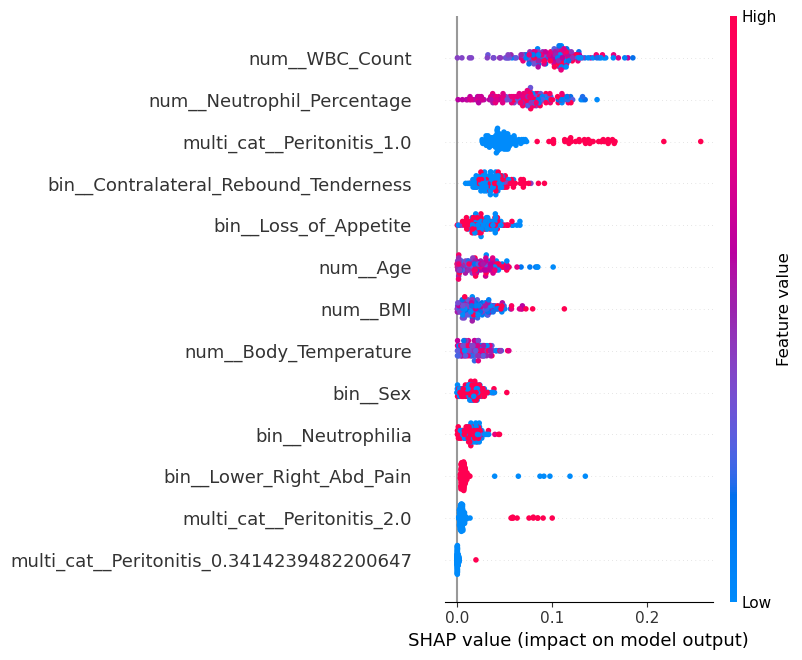

In [28]:
#sensitivity analysis with SHAP values
#Extract the fitted model and preprocessor
rf = best_rf_model.named_steps["model"]
pre = best_rf_model.named_steps["preprocessor"]

#Transform X_val using fitted preprocessor
X_val_transformed = pre.transform(X_val)

#Get correct feature names from fitted preprocessor
feature_names = pre.get_feature_names_out()

#Create SHAP explainer on model
explainer = shap.TreeExplainer(rf)

#Compute SHAP values
shap_values = explainer.shap_values(X_val_transformed)

shap_values_mean = np.mean(np.abs(shap_values), axis=2)  # shape (84, 12)

# Plot summary using mean SHAP values
shap.summary_plot(shap_values_mean, X_val_transformed, feature_names=feature_names)

In [24]:
#print(type(X_val_transformed))
#print(X_val_transformed[:5])

In [25]:
#all_cols = set(X_val.columns)
#used_cols = set(num_feature + cat_feature)

missing_cols = all_cols - used_cols
print("Missing columns in preprocessing:", missing_cols)

NameError: name 'all_cols' is not defined

In [ ]:
#print(pre.get_feature_names_out())